# Trabajo practico III - Visión por computadora I

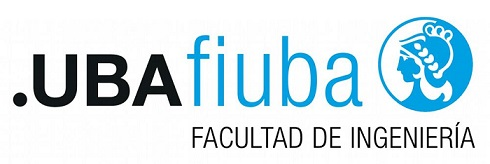

El objetivo de este trabajo práctico es aplicar los concpetos vistos en la clase 4 de la materia visión por computadora I de la Especialización en IA de la FIUBA

Primero cargaremos las libreriás necesarias para trabajar y luego se detalla cada parte y punto a analizar y trabajar, junto a las conclusiones obtenidas

## Cargamos las librerias necesarias

In [1]:
!pip install imutils

In [2]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import os
from imutils.object_detection import non_max_suppression

## Consignas:

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs / images a partir del template Material_TPs / template
1. Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi png con el mismo témplate del item 2
3. Generalizar el algoritmo del item 2 para todas las imágenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección

#### 1. Cargamos la imagen del template, la preprocesamos y la mostramos

In [3]:
path_template = 'template/pattern.png'
template = cv.imread(path_template, cv.IMREAD_GRAYSCALE)
print("Tamaño de template: ", template.shape)

Tamaño de template:  (175, 400)


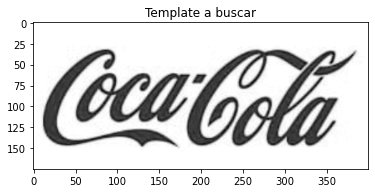

In [4]:
plt.figure(1,figsize=(6,6))
plt.imshow(template,cmap='gray')
plt.title('Template a buscar')
plt.show()

#### 1.1 Aplicamos canny a la imagen del template y la mostramos

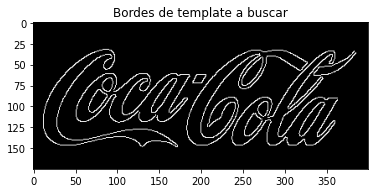

In [5]:
edges_template = cv.Canny(template, 220, 260, apertureSize = 3)
plt.figure(1,figsize=(6,6))
plt.imshow(edges_template,cmap='gray')
plt.title('Bordes de template a buscar')
plt.show()

#### 2. Cargamos las imagenes sobre las cuales buscar el template y vemos sus tamaños

Cantidad de imagenes a analizar:  7 

Imagen  COCA-COLA-LOGO.jpg
Tamaño de imagen:  (1389, 1389, 3)


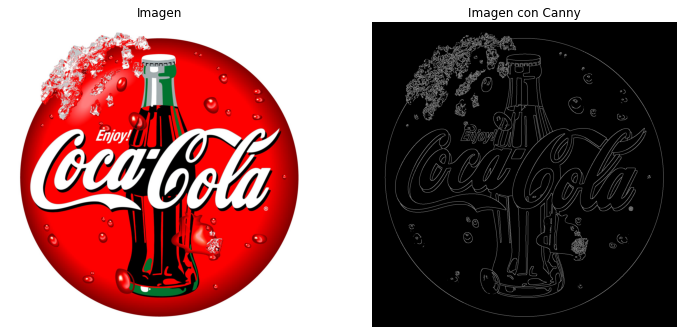



Imagen  coca_logo_1.png
Tamaño de imagen:  (500, 207, 3)


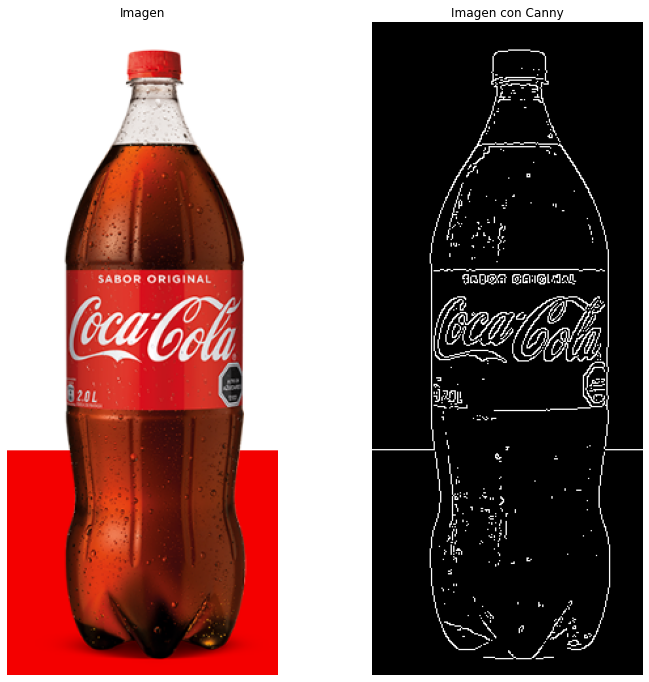



Imagen  coca_logo_2.png
Tamaño de imagen:  (363, 233, 3)


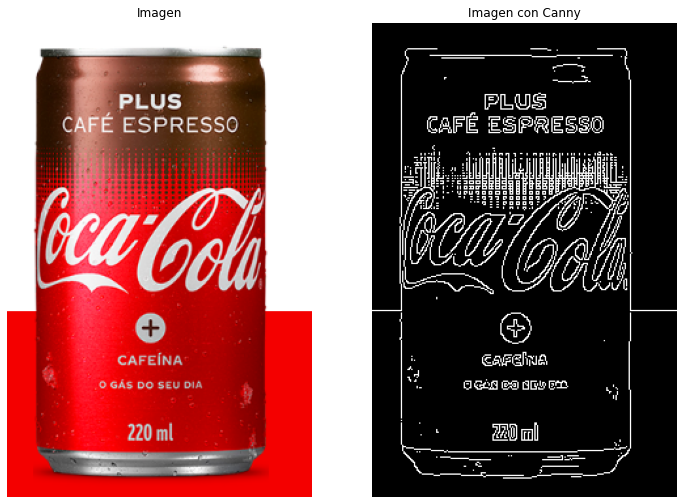



Imagen  coca_multi.png
Tamaño de imagen:  (598, 799, 3)


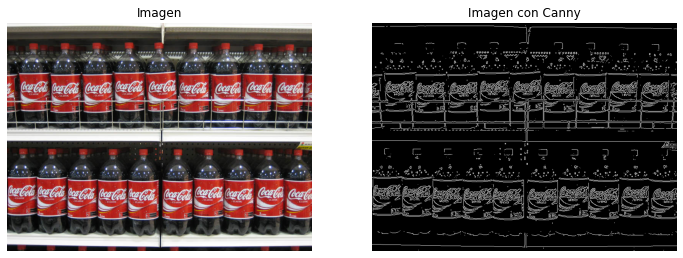



Imagen  coca_retro_1.png
Tamaño de imagen:  (493, 715, 3)


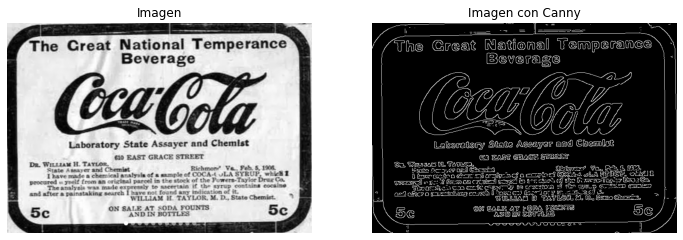



Imagen  coca_retro_2.png
Tamaño de imagen:  (429, 715, 3)


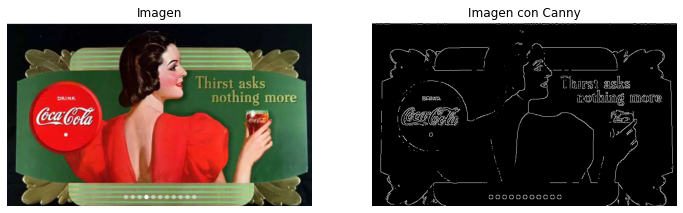



Imagen  logo_1.png
Tamaño de imagen:  (450, 687, 3)


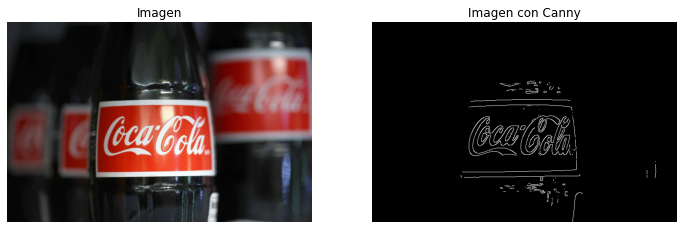

In [6]:
path_base = './images'
imagenes_rutas  = os.listdir(path_base)
print("Cantidad de imagenes a analizar: ",len(imagenes_rutas),"\n")
for img_name in imagenes_rutas:
    #1- Cargo la imagen
    img = cv.imread(path_base+"/"+img_name)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    print("Imagen ",img_name)
    print("Tamaño de imagen: ", img.shape)   
    
    img_canny = cv.Canny(img, 320, 320, apertureSize =3)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title("Imagen")
    plt.imshow(img,cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title("Imagen con Canny")
    plt.imshow(img_canny,cmap='gray')
    plt.show()    
    print("\n") 


#### 3. Generamos una funcion para hacer resize de una imagen en multiples resoluciones y steps

In [7]:
def generar_escalas(imagen:np.ndarray,escala_min_porc=50,escala_max_porc=300,porc_salto=5):
    img_escalas = []
    
    width_img = imagen.shape[1]
    height_img = imagen.shape[0]
    
    scale_percent = 60 # percent of original size
    escalas = np.arange(escala_min_porc,escala_max_porc+porc_salto,porc_salto)
    for escala in escalas:
        width = int(width_img * escala / 100)
        height = int(height_img * escala / 100)
        img_escalas.append(
                cv.resize(imagen, 
                          (width,height), 
                          interpolation=cv.INTER_AREA if escala <= 100 else cv.INTER_CUBIC)
                )
    return img_escalas
    
    
    

##### 3.1 Probamos la funcion con el template original

In [8]:
img_escaladas = generar_escalas(template,50,300,50)

Tamaño de imagen:  (87, 200)


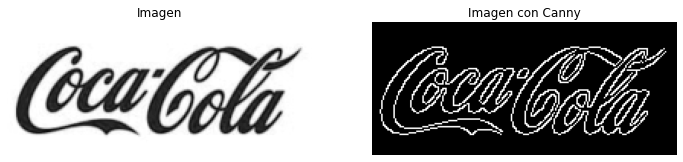



Tamaño de imagen:  (175, 400)


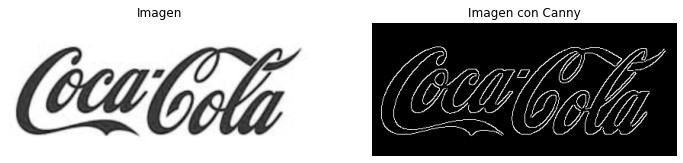



Tamaño de imagen:  (262, 600)


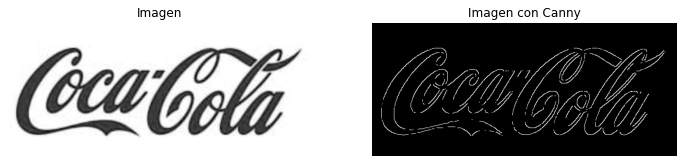



Tamaño de imagen:  (350, 800)


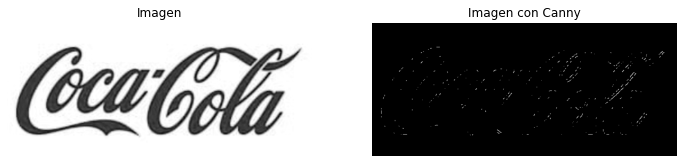



Tamaño de imagen:  (437, 1000)


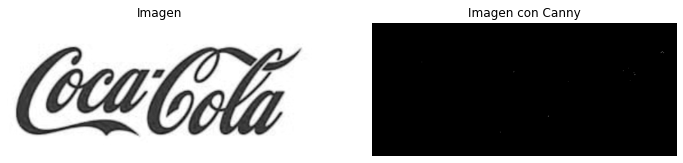



Tamaño de imagen:  (525, 1200)


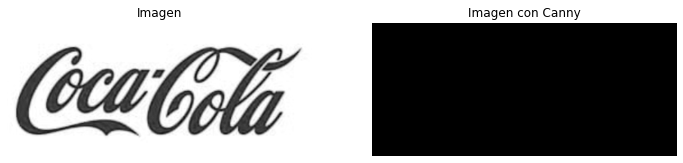

In [9]:
for img in img_escaladas:
    
    img_canny = cv.Canny(img, 320, 320, apertureSize =3)
    print("Tamaño de imagen: ", img.shape)   
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title("Imagen")
    plt.imshow(img,cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title("Imagen con Canny")
    plt.imshow(img_canny,cmap='gray')
    plt.show()    
    print("\n") 


Vemos que la imagen escala bien pero la imagen de bordes se pierde.
Probamos escalar directamente la imagen de bordes para ver los resultados

##### 3.2 Probamos el escalado con la imagen de bordes

In [10]:
img_escaladas = generar_escalas(edges_template,50,300,50)

Tamaño de imagen:  (87, 200)


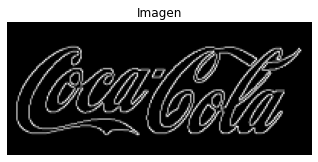



Tamaño de imagen:  (175, 400)


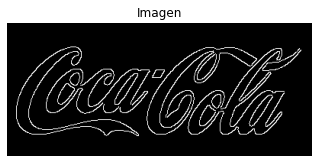



Tamaño de imagen:  (262, 600)


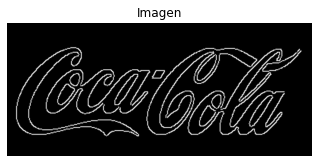



Tamaño de imagen:  (350, 800)


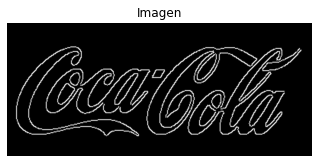



Tamaño de imagen:  (437, 1000)


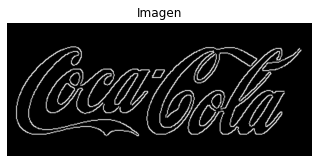



Tamaño de imagen:  (525, 1200)


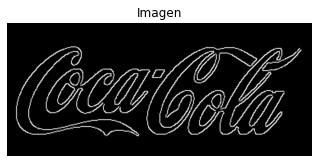

In [11]:
for img in img_escaladas:
    
    print("Tamaño de imagen: ", img.shape)   
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title("Imagen")
    plt.imshow(img,cmap='gray')
    plt.show()    
    print("\n") 

De este modo la imagen no se modifica con las diferentes escalas

#### 4. Generamos la función de detección

In [21]:
def detectarLogo(template_in:np.ndarray,
                 imagen:np.ndarray,
                 method = cv.TM_CCOEFF_NORMED,
                 mostrar_escalas=False,
                 umbral=None    
                ):
    '''
    Esta función permite hacer template matching tomando diferentes parámetros de entrada.
    template_in: la imagen de template 
    imagen: la imagen sobre la cual hacer el matching
    method: metodo a aplicar para determinar el matching
    mostrar_escalas: booleano que permite mostrar las diferentes resoluciones a las que se probará el template para el matching
    umbral: si es None se busca una única detección, sino se hace una busqueda múltiple por umbral
    
    El template matching se hace sobre las imagenes de borde, para lo cual aplicamos canny a la imagen y al template.
    Para hacer el template matching primero generamos varias resoluciones del template.
    Tomamos en cuenta la resolución de la imagen y la del template y su ratio para generar diferentes escalas
    
    Luego iteramos sobre cada una de los templates a diferentes resoluciones. 
    En cada iteración se hace el template matching.
    Si el score obtenido es mejor que en el paso anterior se guarda la imagen de match y la imagen con el box del template matching
    en una variable auxiliar.
    Luego de todas las iteraciones se muestra el mejor match y score obtenido.
    '''    
    
    color_box = (0, 255, 0)
    #Aplicamos canny sobre la imagen y el template
    template_canny = cv.Canny(template_in, 260, 260, apertureSize = 3)#220 260
    imagen_gray = cv.cvtColor(imagen,cv.COLOR_RGB2GRAY)
    imagen_canny = cv.Canny(imagen_gray, 260, 260, apertureSize = 3)  
    img_salida = imagen.copy()
    
    #############################################
    ## Calculos para resoluciones del template ## 
    ##############################################
    #Miro resolucion imagen y busco template hasta un maximo de su resolucion
    min_factor = 60
    max_factor = 95
    cant_steps = 20
   
    w_temp, h_temp = template_in.shape[::-1]  
    w_img, h_img = imagen_gray.shape[::-1]  
    #Genero diferentes resoluciones de template y diferentes rangos
    w_max_img = w_img
    h_max_img = h_img  
    factor_w = (w_img/w_temp)*0.9
    if factor_w == 0:
        factor_w = 1
    ratio = w_img / h_img   
    if ratio > 1:
        min_factor = 10
        max_factor = 15
    if ratio > 1.45:
        min_factor = 30
        max_factor = 60

    factor_h = (h_img/h_temp)
    #Minimo de 100 pixeles para que no se deforme mucho la imagen
    min_px_w = 120
    min_factor_px = int((min_px_w*100) / (w_temp*factor_w))
    if min_factor_px>min_factor:
        min_factor = min_factor_px
    #El factor maximo no debe sobrepasar el tamanio de la imagen
    fact_lim_max = int((w_img*100) / (factor_w * w_temp))
    if max_factor > fact_lim_max:
        max_factor = fact_lim_max
    

    templates_escalas = generar_escalas(template_canny,int(factor_w*min_factor),int(factor_w*max_factor),(factor_w*cant_steps))  
    
    
    ## Opcion para ver las escalas utilizadas y los templates a esas escalas
    if mostrar_escalas:
        for template_esc in templates_escalas:

            print("Tamaño de template: ", template_esc.shape)   
            plt.figure(figsize=(8,8))
            plt.axis('off')
            plt.title("template")
            plt.imshow(template_esc,cmap='gray')
            plt.show()    
            print("\n") 
            
    ##############################
    ### Hago template matching ###
    ##############################
       
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        mejor_score = 100
    else:
        mejor_score = 0
    cambio_score = False
    confianza = 0
    tamanio_template_match = ""
    
    for template_esc in templates_escalas:
        
        match = cv.matchTemplate(imagen_canny, template_esc, method)   
        cv.normalize( match, match, 0, 1, cv.NORM_MINMAX, -1 )
        w, h = template_esc.shape[::-1] 
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match)
        
        if umbral is None:
            # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                top_left = min_loc
                score = min_val
                if score <= mejor_score:
                    mejor_score = score
                    cambio_score = True
            else:
                top_left = max_loc
                score = max_val
                if score >= mejor_score:
                    mejor_score = score
                    cambio_score = True    

            if cambio_score:
                if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                    confianza = (1 - mejor_score)*100
                else:
                    confianza = mejor_score*100
                # Marcamos el lugar donde lo haya encontrado
                bottom_right = (top_left[0] + w, top_left[1] + h)
                tamanio_template_match = f"Mejor match con template a resolucion height: {h} - width: {w}"
                img_salida = imagen.copy()
                cv.rectangle(img_salida,top_left, bottom_right, color_box, 4)
                cv.putText(img_salida, f"Confianza: {confianza:.3f}", (top_left[0],top_left[1]-12), cv.FONT_HERSHEY_SIMPLEX, 0.9, color_box, 2)
                match_salida = match.copy()
        else:
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                (y_points, x_points) = np.where((match <= umbral))
            else:
                (y_points, x_points) = np.where((match >= umbral))
                mejor_score = match[y_points[0]][x_points[0]]
            
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                confianza = (1 - mejor_score)*100
            else:
                confianza = mejor_score*100
                
            # Armo lista de boxes
            boxes = list()
            for (x, y) in zip(x_points, y_points):
                # Agrego cada box a la lista
                boxes.append((x, y, x + w, y + h))
    
            if len(boxes) > 0:
                # Aplico non_max_suppression
                boxes = non_max_suppression(np.array(boxes),overlapThresh=0.35)
                # Hago loop sobre los boxes
                tamanio_template_match = f"Mejor match con template a resolucion height: {h} - width: {w}"
                img_salida = imagen.copy()
                for (x1, y1, x2, y2) in boxes:
                    # Y dibujo el rectangulo
                    cv.rectangle(img_salida, (x1, y1), (x2, y2),
                              color_box, 4)
                    score_pto = match[y1][x1]
                    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                        conf_pto = (1 - score_pto)*100
                        if score_pto <= mejor_score:
                            mejor_score = score_pto
                            confianza = (1 - mejor_score)*100
                    else:
                        conf_pto = score_pto*100   
                        if score_pto >= mejor_score:
                            mejor_score = score_pto
                            confianza = mejor_score*100
                    cv.putText(img_salida, f"{conf_pto:.1f}", (x1, y1-12), cv.FONT_HERSHEY_SIMPLEX, 0.9, color_box, 2)
                match_salida = match.copy()                

    # Muestro resultado de la coincidencia
    #plt.subplot(121),plt.imshow(match_salida,cmap = 'gray')
    print(tamanio_template_match)
    plt.figure(1,figsize=(10,10))
    plt.imshow(img_salida)
    titulo = f"Mejor score obtenido : {confianza:.3f}"
    plt.suptitle(titulo)
    plt.show()               
 

#### 5. Probamos la función de detección con nuestra imagenes

imagen  COCA-COLA-LOGO.jpg  .Shape:  (1389, 1389, 3)
Mejor match con template a resolucion height: 546 - width: 1248


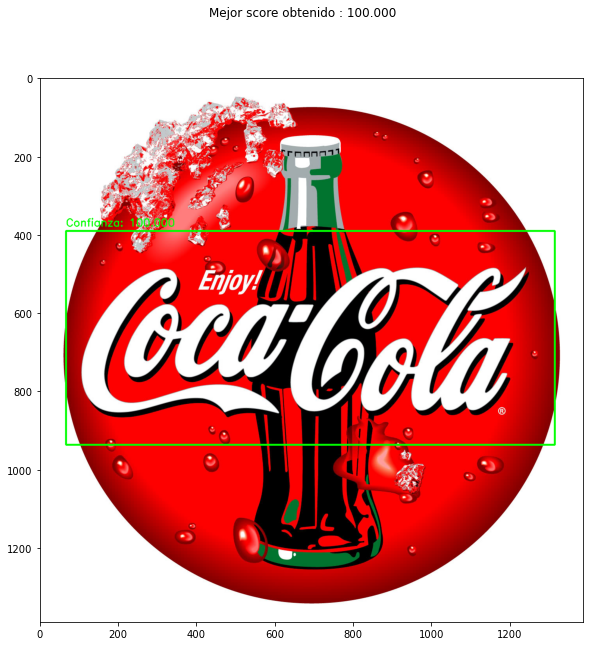

imagen  coca_logo_1.png  .Shape:  (500, 207, 3)
Mejor match con template a resolucion height: 83 - width: 190


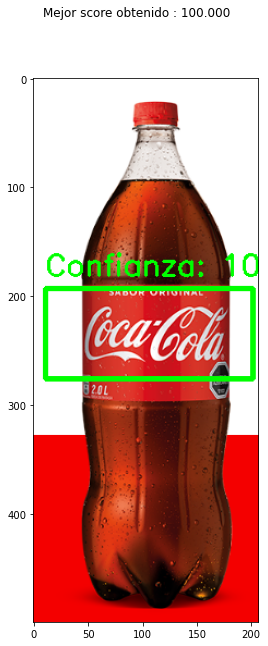

imagen  coca_logo_2.png  .Shape:  (363, 233, 3)
Mejor match con template a resolucion height: 90 - width: 207


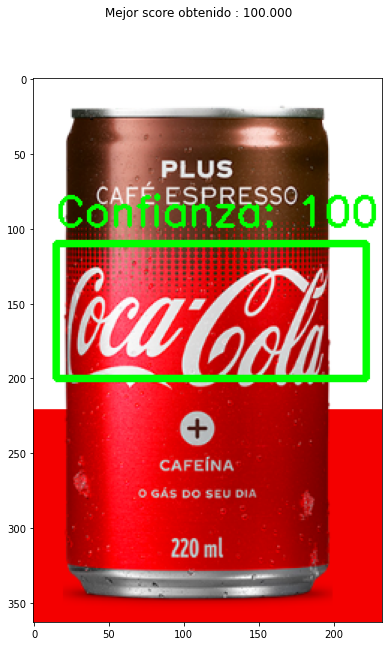

imagen  coca_multi.png  .Shape:  (598, 799, 3)
Mejor match con template a resolucion height: 49 - width: 112


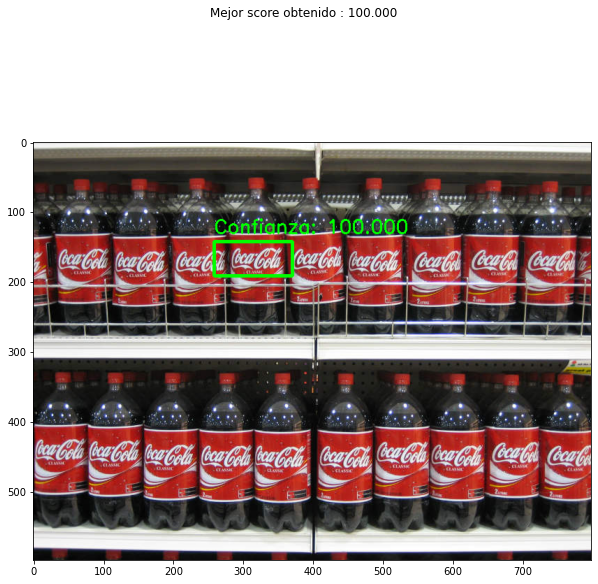

imagen  coca_retro_1.png  .Shape:  (493, 715, 3)
Mejor match con template a resolucion height: 196 - width: 449


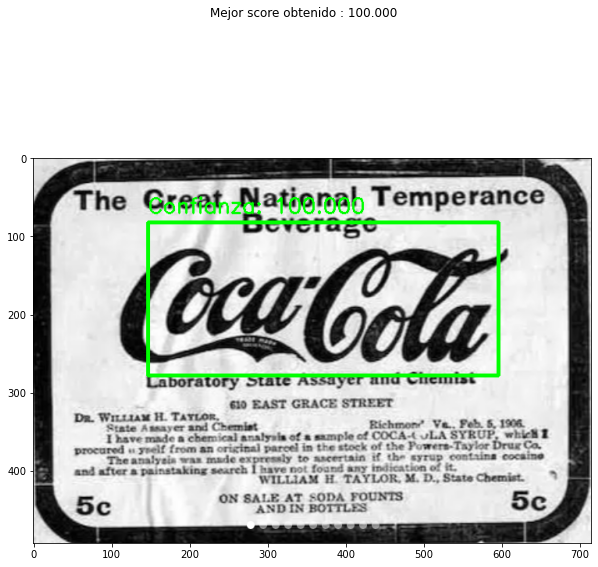

imagen  coca_retro_2.png  .Shape:  (429, 715, 3)
Mejor match con template a resolucion height: 196 - width: 449


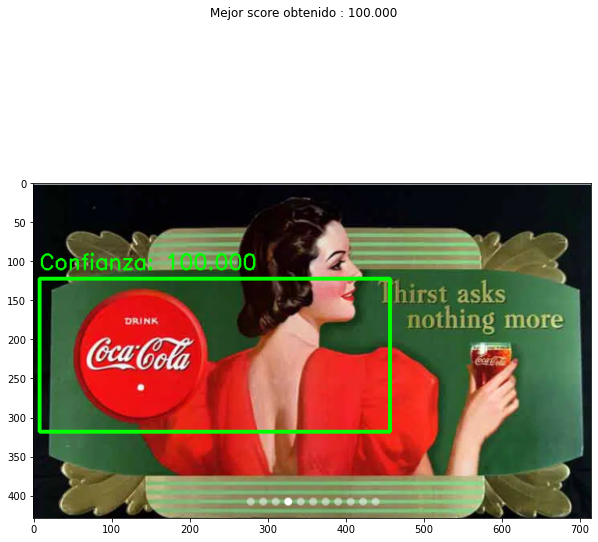

imagen  logo_1.png  .Shape:  (450, 687, 3)
Mejor match con template a resolucion height: 188 - width: 431


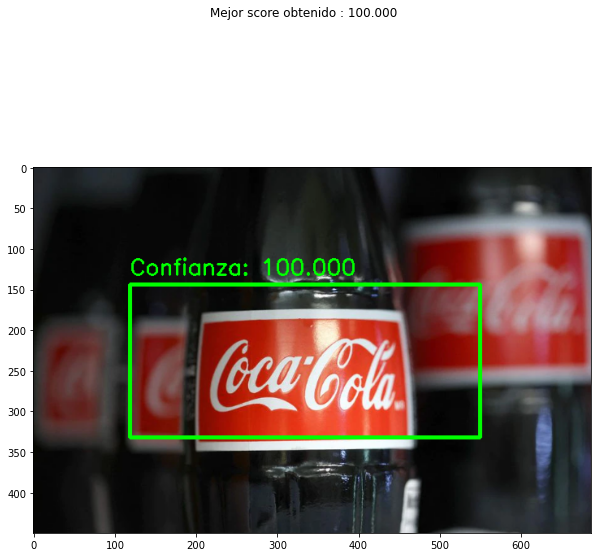

In [22]:
for img_name in imagenes_rutas:
    img = cv.imread(path_base+"/"+img_name)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    print("imagen ",img_name ," .Shape: ",img.shape)
    detectarLogo(template_in=template,imagen=img,method = cv.TM_CCOEFF_NORMED)


#### 6. Probamos nuestra función para detección multiple

imagen  coca_multi.png  .Shape:  (598, 799, 3)
Mejor match con template a resolucion height: 49 - width: 112


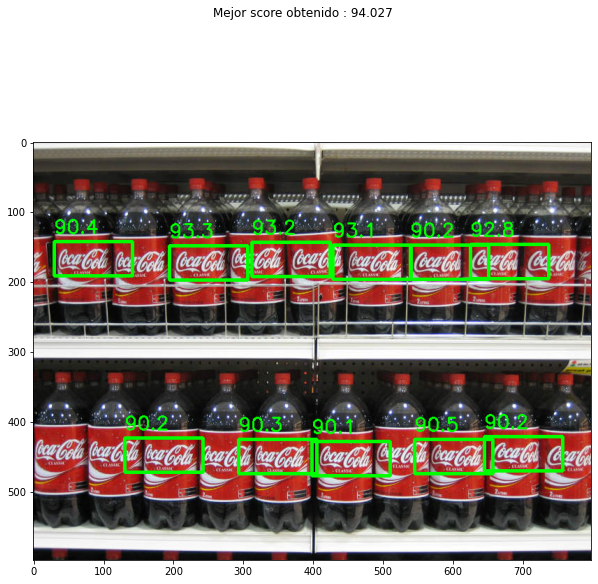

In [23]:
img_name = "coca_multi.png"
img = cv.imread(path_base+"/"+img_name)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
print("imagen ",img_name ," .Shape: ",img.shape)
detectarLogo(template_in=template,
             imagen=img,
             method =cv.TM_CCOEFF_NORMED,
             mostrar_escalas=False,
             umbral=0.9#0.138#0.129
             )


#### Conclusiones

* Se logro armar una función para detección simple y múltiple
* Fue importante analizar el uso de imágenes de borde para hacer el template matching y analizar el mejor modo de hacer el escalado del template para lograr buenas resoluciones, evitar el difumado de la imagen y asegurar un buen matcheo
* el uso de min_max_suppression fue importante en el matcheo múltiple para evitar solapamiento de matcheos y lograr buenos resultados